In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, Conv2D, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [4]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\efe0fa53-e776-11ef-9116-bf566531ff0d.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[100:120+250,150:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(r'A:\data\anchor', '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(r'A:\data\positive', '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()



KeyboardInterrupt: 

In [5]:
anchor = tf.data.Dataset.list_files(r'A:\data\anchor'+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(r'A:\data\positive'+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(r'A:\data\negative'+'/*.jpg').take(400)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [10]:
samples = data.as_numpy_iterator()
example = samples.next()

1.0

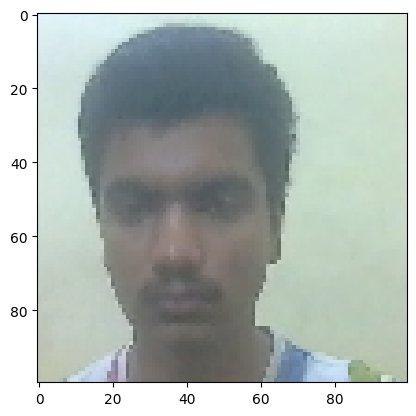

In [11]:
res = preprocess_twin(*example)
plt.imshow(res[1])
res[2]

In [12]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [14]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')


    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)


    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [15]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super(L1Dist,self).__init__()

    def call(self, input_embedding, validation_embedding):
       input_embedding = tf.convert_to_tensor(input_embedding)
       validation_embedding = tf.convert_to_tensor(validation_embedding)
       return tf.math.abs(input_embedding - validation_embedding)

In [16]:
l1 = L1Dist()

In [17]:
embedding = make_embedding()

In [18]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [20]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [22]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [25]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [27]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        yhat = tf.squeeze(yhat, axis=0)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        tf.print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [28]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
0.370050192
 1/35 ━━━━━━━━━━━━━━━━━━━━ 33s 991ms/step0.265913188
 2/35 ━━━━━━━━━━━━━━━━━━━━ 26s 806ms/step0.428007364
 3/35 ━━━━━━━━━━━━━━━━━━━━ 25s 799ms/step0.313423336
 4/35 ━━━━━━━━━━━━━━━━━━━━ 25s 811ms/step0.33321768
 5/35 ━━━━━━━━━━━━━━━━━━━━ 24s 823ms/step0.162792578
 6/35 ━━━━━━━━━━━━━━━━━━━━ 23s 824ms/step0.308033437
 7/35 ━━━━━━━━━━━━━━━━━━━━ 23s 828ms/step0.341552198
 8/35 ━━━━━━━━━━━━━━━━━━━━ 22s 831ms/step0.187017709
 9/35 ━━━━━━━━━━━━━━━━━━━━ 21s 838ms/step0.138000309
10/35 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step0.266523212
11/35 ━━━━━━━━━━━━━━━━━━━━ 20s 845ms/step0.157606229
12/35 ━━━━━━━━━━━━━━━━━━━━ 19s 845ms/step0.1287117
13/35 ━━━━━━━━━━━━━━━━━━━━ 18s 847ms/step0.146777615
14/35 ━━━━━━━━━━━━━━━━━━━━ 17s 849ms/step0.243983045
15/35 ━━━━━━━━━━━━━━━━━━━━ 16s 847ms/step0.154481873
16/35 ━━━━━━━━━━━━━━━━━━━━ 16s 849ms/step0.157832652
17/35 ━━━━━━━━━━━━━━━━━━━━ 15s 850ms/step0.0865610838
18/35 ━━━━━━━━━━━━━━━━━━━━ 14s 854ms/step0.183135808
19/35 ━━━━━━━━━━━━━━━━━

In [41]:
from tensorflow.keras.metrics import Precision, Recall


In [42]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [43]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


array([[[0.00163196],
        [0.5372479 ],
        [0.5372479 ],
        [0.00163196],
        [0.00163196],
        [0.5372478 ],
        [0.00163196],
        [0.5372479 ],
        [0.00163196],
        [0.00163196],
        [0.5372479 ],
        [0.5372479 ],
        [0.5372479 ],
        [0.00163196],
        [0.00163196],
        [0.00163196]]], dtype=float32)

In [44]:
for i in range(len(y_hat)):
    if y_hat[0,i,0] > 0.5:
        y_hat[0,i,0] = 1
    else:
        y_hat[0,i,0] = 0

In [45]:
y_true

array([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [46]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [47]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

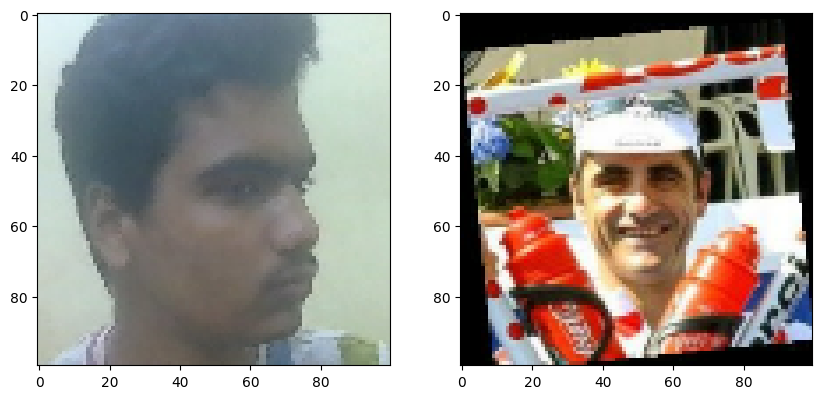

In [48]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [49]:
# Save weights
siamese_model.save('siamesemodel.keras')

In [50]:
L1Dist

__main__.L1Dist

In [51]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.keras',custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [52]:
# Make predictions with reloaded model
model.predict([test_input, test_val])
import numpy as np
from sklearn.metrics import accuracy_score

# Ensure predictions are flattened correctly
y_hat_flat = y_hat.flatten()

# Threshold predictions at 0.5 to get binary output
y_pred = np.where(y_hat_flat > 0.5, 1, 0)

# Ensure true labels are also flattened
y_true_flat = y_true.flatten()

# Check shapes before calculating accuracy
print(f'y_pred shape: {y_pred.shape}, y_true shape: {y_true_flat.shape}')

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
y_pred shape: (16,), y_true shape: (16,)
Accuracy: 100.00%


In [53]:
# View model summary

model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
os.listdir(os.path.join(r'A:\application_data', 'verification_images'))

['000bac73-e259-11ef-9539-3ce9f7d1a5eb.jpg',
 '00e945e6-e259-11ef-abeb-3ce9f7d1a5eb.jpg',
 '00edf2df-e259-11ef-8c35-3ce9f7d1a5eb.jpg',
 '00f282ed-e259-11ef-aeb3-3ce9f7d1a5eb.jpg',
 '00f73f20-e259-11ef-aa6a-3ce9f7d1a5eb.jpg',
 '01a94d09-e259-11ef-a3ab-3ce9f7d1a5eb.jpg',
 '01b7879d-e259-11ef-8d15-3ce9f7d1a5eb.jpg',
 '02bd7dbd-e259-11ef-abb9-3ce9f7d1a5eb.jpg',
 '02d046ce-e259-11ef-a7f4-3ce9f7d1a5eb.jpg',
 '02de4961-e259-11ef-aa8c-3ce9f7d1a5eb.jpg',
 '03a75592-e259-11ef-8ea1-3ce9f7d1a5eb.jpg',
 '03b61049-e259-11ef-b4ba-3ce9f7d1a5eb.jpg',
 '04b176bd-e259-11ef-9268-3ce9f7d1a5eb.jpg',
 '04b6049b-e259-11ef-8ea2-3ce9f7d1a5eb.jpg',
 '04ba9eff-e259-11ef-a0ae-3ce9f7d1a5eb.jpg',
 '04cdaed1-e259-11ef-b3a6-3ce9f7d1a5eb.jpg',
 '04e55d41-e259-11ef-b5c1-3ce9f7d1a5eb.jpg',
 '04ea3c80-e259-11ef-a83a-3ce9f7d1a5eb.jpg',
 '04ef98c6-e259-11ef-8ed3-3ce9f7d1a5eb.jpg',
 '04f5fd72-e259-11ef-b0bd-3ce9f7d1a5eb.jpg',
 '08bb4fc0-e259-11ef-ac90-3ce9f7d1a5eb.jpg',
 '08c00d0d-e259-11ef-b893-3ce9f7d1a5eb.jpg',
 '08ce934e

In [55]:
os.path.join(r'A:\application_data', 'input_image', 'input_image.jpg')

'A:\\application_data\\input_image\\input_image.jpg'

In [56]:
for image in os.listdir(os.path.join(r'A:\application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\000bac73-e259-11ef-9539-3ce9f7d1a5eb.jpg
application_data\verification_images\00e945e6-e259-11ef-abeb-3ce9f7d1a5eb.jpg
application_data\verification_images\00edf2df-e259-11ef-8c35-3ce9f7d1a5eb.jpg
application_data\verification_images\00f282ed-e259-11ef-aeb3-3ce9f7d1a5eb.jpg
application_data\verification_images\00f73f20-e259-11ef-aa6a-3ce9f7d1a5eb.jpg
application_data\verification_images\01a94d09-e259-11ef-a3ab-3ce9f7d1a5eb.jpg
application_data\verification_images\01b7879d-e259-11ef-8d15-3ce9f7d1a5eb.jpg
application_data\verification_images\02bd7dbd-e259-11ef-abb9-3ce9f7d1a5eb.jpg
application_data\verification_images\02d046ce-e259-11ef-a7f4-3ce9f7d1a5eb.jpg
application_data\verification_images\02de4961-e259-11ef-aa8c-3ce9f7d1a5eb.jpg
application_data\verification_images\03a75592-e259-11ef-8ea1-3ce9f7d1a5eb.jpg
application_data\verification_images\03b61049-e259-11ef-b4ba-3ce9f7d1a5eb.jpg
application_data\verification_images\04b176bd-e259-11ef-9268-3ce

In [59]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join(r'A:\application_data', 'verification_images')):
        input_img = preprocess(os.path.join(r'A:\application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(r'A:\application_data', 'verification_images', image))
        
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    

    detection = np.sum(np.array(results) > detection_threshold)
    
 
    verification = detection / len(os.listdir(os.path.join(r'A:\application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [60]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join(r'A:\application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━

In [ ]:
np.sum(np.squeeze(results) > 0.9)